In [1]:
from bs4 import BeautifulSoup as soup
import requests
import pandas as pd
import time

start_time = time.time()
end_time = 0

domain = "https://www.bolha.com"
params = ['Znamka avtomobila:', 'Model avtomobila:', 'Tip avtomobila:', 'Leto izdelave:', 'Prevoženi kilometri:']
results_df = pd.DataFrame(data=None, index=None, columns=params.append('Cena:'))
results_df.index +=1

page_number = '1'
ad_number = 1

# Individual page processing
while int(page_number) <= 50:
    request_page = requests.get(domain + '/rabljeni-avtomobili?page=' + page_number)
    page_soup = soup(request_page.content,'html.parser')
#     print(page_number)

    page_cars_html = page_soup.find_all('h3',{'class':'entity-title'})
#     print(len(page_cars_html))
    
    # Individual car processing
    for car_html in page_cars_html:
        single_car_url = car_html.a.get('href')
        
        if 'avto-oglasi' in single_car_url:
#             print(single_car_url)
            single_car_req = requests.get(domain + single_car_url)
            car_info = soup(single_car_req.content,'html.parser')

            car_price_html = car_info.find('li',{'class':'price-item--base'}).find('strong',{'class':'price'})
            car_price = car_price_html.get_text().replace('\n','').replace(' ','').replace('\xa0',' ')
            #car_table = car_info.find('tbody').find_all('tr')
            #car_type = car_table[2].find('td').text + ' ' + car_table[3].find('td').text + ', '+ car_table[4].find('td').text
            #car_year = car_table[5].find('td').text
            #car_mileage = car_table[10].find('td').text

            # Find table of properties I'm interested in.
            my_list = car_info.find('tbody')
            result_dict = {'Cena:':car_price, 'Stran:':page_number, 'Oglas:':str(ad_number)}
#             print(result_dict.values())

            # Loops across all parameters, finds the index, takes result, stores in a dictionary
            for param in params:
                for i,each_param in enumerate(my_list.find_all('th')):
                    if param in each_param:
                        value = my_list.find_all('tr')[i].find('td').text
                        if value is not None:
                            result_dict.update({param : value})
                            
            #Once an individual ad is processed, increment of ad_number.
            ad_number +=1

            # Dictionary of results is stored in results dataframe only if it found properties other than price
            # Only include prices greater than 99 €
            # Exclude ads with no defined price
            if result_dict['Znamka avtomobila:'] is not None and \
                result_dict['Model avtomobila:'] is not None and \
                result_dict['Tip avtomobila:'] is not None and \
                result_dict['Leto izdelave:'] is not None and \
                result_dict['Prevoženi kilometri:'] is not None and \
                len(result_dict['Cena:']) > 4 and \
                "dogovor" not in result_dict['Cena:'] :
                results_df = results_df.append(result_dict, ignore_index=True)
#                 print("Stran: " + str(page_number))

#             print("Next car!")
        else:
            pass
#             print("Not a car!")

            
    # Find a link to next page; if not there, break the while loop
    try:
        page_number = page_soup.find('li',{'class':'Pagination-item--next'}).find('button').get('data-page')
#         print("New: "+page_number)
    except AttributeError:
        print("Done!")
#         end_time = time.time()
        break
    else:
        continue
    break
                
                
print("Runtime: %s seconds" % (round(time.time() - start_time, 2)))

Runtime: 1048.01 seconds


#### Edit data

In [ ]:
# filter_1 = ~results_df['Leto izdelave:'].isnull()
# filter_2 = 
#msno.matrix(results_df[~results_df['Leto izdelave:'].isnull()])
# plt.plot(results_df['Leto izdelave:'],'.')
# plt.plot('Cena:', 'Leto izdelave:')

# results_df.info()
# results_df = results_copy.copy(deep=True)
# results_copy = results_df.copy(deep=True)
# results_df['Cena:'][~results_df['Cena:'].str.contains('€')]
# temp_result = results_df['Cena:'].str.slice(stop = -2)
# temp_result = temp_result.str.replace('.','')
# temp_result = temp_result.str.replace(',','.')
# results_df['Cena:'] = temp_result
# temp_result = results_df['Prevoženi kilometri:'].str.slice(stop = -3)
# results_df['Prevoženi kilometri:'] = temp_result
# col_key = results_df.columns.to_list()
# col_val = [key[:-1] for key in col_key]
# col_dict = {col_key[i]:col_val[i] for i in range(len(col_key))}
# results_df = results_df.rename(columns=col_dict)
# temp = ['Oglas','Stran','Znamka avtomobila','Tip avtomobila','Model avtomobila','Leto izdelave','Prevoženi kilometri','Cena']
# results_df = results_df[temp]
# results_df.columns = [temp]
# type_dict = {'Cena':'float64','Prevoženi kilometri':'int64','Leto izdelave':'int64'}
# results_df = results_df.astype(dtype=type_dict)
results_df

### Storage of results

In [218]:
# Vzpostavi SQLite bazo, vnesi rezultate scrapinga sem notri. Kako posodobiti? Preveriti vsak vnos znova? To utegne trajati.
from sqlalchemy import create_engine
# import sqlite3

engine = create_engine('sqlite:///car_storage.db', echo=False)
conn = engine.connect()

results_df.to_sql('car_ads', conn, if_exists='fail')
conn.close()

### Retrieve results

In [1]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('sqlite:///car_storage.db', echo=False)
conn = engine.connect()

sql = '''select * from car_ads where 1=1;'''

data = pd.read_sql(sql, conn, index_col='index')
data.index.name=''

In [3]:
data

,Oglas,Stran,Znamka avtomobila,Tip avtomobila,Model avtomobila,Leto izdelave,Prevoženi kilometri,Cena
,,,,,,,,
0,1,1,Audi,DPF 2.0 TDI-e,A4 Avant,2010,313000,7500.0
1,2,1,Renault,Grand Passenger Dynamique,Trafic,2019,29500,23900.0
2,3,1,Renault,Grandtour 1.5,Laguna,2008,240000,3800.0
3,4,1,Renault,KWOCB6,Kangoo,2009,225000,4500.0
4,5,1,Mercedes-Benz,111,Vito,2017,68500,11950.0
...,...,...,...,...,...,...,...,...
914,1395,50,Opel,cc,Kadett,1979,60000,200.0
915,1397,50,Renault,N/A,Laguna Grandtour,2005,256386,2000.0
916,1398,50,Renault,KWOCB6,Kangoo,2009,225000,4500.0


## Analiza

(0.0, 1000000.0)

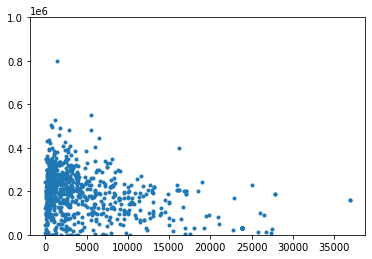

In [10]:
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.plot(data['Cena'],data['Prevoženi kilometri'],'.')
plt.ylim([0,1e6])

In [ ]:
# data[data['Znamka avtomobila'].isin(populars)]
# results_df[results_df['Znamka avtomobila'].isin(populars)]

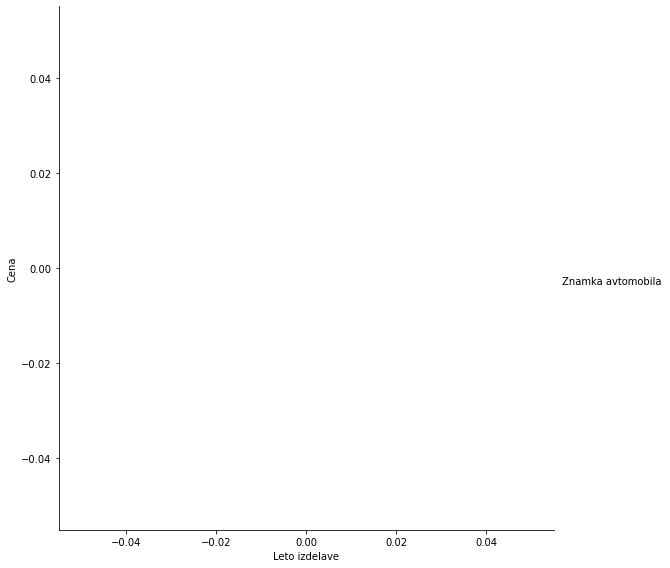

In [23]:
populars = list(data.groupby('Znamka avtomobila')['Oglas'].count().sort_values(ascending=False)[0:5].index)
my_data = data[data['Znamka avtomobila'].isin([populars])]

X = my_data['Leto izdelave']
Y = my_data['Cena']
Z = my_data['Prevoženi kilometri']

# plt.plot(X,Y,'.')

# x_fit = np.arange(1970,2021,1)
# y_fit = np.exp(0.184 *x_fit -361.315)
# y_fit = np.exp(0.2083 *x_fit -410.77)



# plt.plot(x_fit,y_fit)
sns.lmplot(data=my_data, x='Leto izdelave', y='Cena', hue='Znamka avtomobila', height=8, fit_reg=False)
# sns.regplot(X, Y, fit_reg=False, order=1, logx=True)
# sns.lmplot(data=my_data[my_data['Znamka avtomobila']=='Renault'], x='Leto izdelave', y='Cena', height=8)


# plt.plot([1996,2020],[5,10], linewidth=5, color='orange')
# plt.plot([1995,],[5,], linewidth=4, color='green')
# plt.ylim(4, 10)
# plt.xlim(0, 1e6)
# plt.rcParams['figure.figsize'] = [10,8]# v inčah!
# plt.show()
# plt.plot(X,Y,'.')
# plt.plot(Y,'.-')

In [50]:
from tqdm import tqdm

A = np.arange(0.15,0.25,0.001)
B = np.arange(-450,-400,1)
# B = -410.77

def grad_desc(a,b,alpha,epoch):
    for i in range(epoch):
        temp = np.log(Y) - (a*X + b)
        temp_a = sum(temp) /temp.shape[0]
        temp_b = sum(temp *X) /temp.shape[0]
        
        a = a -alpha *temp_a
        b = b -alpha *temp_b
    return(round(a,3), round(b,3))

res_A = list()
res_B = list()

for b in tqdm(B):
    for a in A:
        res_a, res_b = grad_desc(a,b,0.001,20)
        res_A.append(res_a)
        res_B.append(res_b)
        
#         min(res_A)
#         min(res_B)

100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


In [51]:
# print(grad_desc(0.2, -214, 0.01, 1000))
# res_A
res_A

[-4009381112874.135,
 -3957994496889.033,
 -3906607880903.916,
 -3855221264918.823,
 -3803834648933.726,
 -3752448032948.626,
 -3701061416963.515,
 -3649674800978.412,
 -3598288184993.301,
 -3546901569008.24,
 -3495514953023.108,
 -3444128337038.008,
 -3392741721052.906,
 -3341355105067.817,
 -3289968489082.715,
 -3238581873097.631,
 -3187195257112.51,
 -3135808641127.41,
 -3084422025142.313,
 -3033035409157.224,
 -2981648793172.112,
 -2930262177187.016,
 -2878875561201.915,
 -2827488945216.808,
 -2776102329231.704,
 -2724715713246.612,
 -2673329097261.494,
 -2621942481276.408,
 -2570555865291.314,
 -2519169249306.199,
 -2467782633321.11,
 -2416396017336.014,
 -2365009401350.914,
 -2313622785365.835,
 -2262236169380.706,
 -2210849553395.616,
 -2159462937410.505,
 -2108076321425.402,
 -2056689705440.314,
 -2005303089455.214,
 -1953916473470.1,
 -1902529857485.008,
 -1851143241499.907,
 -1799756625514.81,
 -1748370009529.703,
 -1696983393544.618,
 -1645596777559.51,
 -1594210161574.408,


In [134]:
x_fit = np.arange(1970,2021,1)
y_fit = np.exp(0.184 *x_fit -361.315)
print(y_fit)

[3.20592288e+00 3.85357003e+00 4.63205216e+00 5.56779998e+00
 6.69258368e+00 8.04459148e+00 9.66972625e+00 1.16231640e+01
 1.39712270e+01 1.67936359e+01 2.01862161e+01 2.42641512e+01
 2.91658936e+01 3.50578656e+01 4.21401092e+01 5.06530781e+01
 6.08858013e+01 7.31856966e+01 8.79703653e+01 1.05741771e+02
 1.27103282e+02 1.52780156e+02 1.83644165e+02 2.20743192e+02
 2.65336810e+02 3.18939044e+02 3.83369778e+02 4.60816539e+02
 5.53908771e+02 6.65807107e+02 8.00310678e+02 9.61986099e+02
 1.15632251e+03 1.38991796e+03 1.67070338e+03 2.00821189e+03
 2.41390247e+03 2.90154897e+03 3.48770777e+03 4.19227993e+03
 5.03918681e+03 6.05718228e+03 7.28082894e+03 8.75167159e+03
 1.05196477e+04 1.26447830e+04 1.51992293e+04 1.82697141e+04
 2.19604854e+04 2.63968510e+04 3.17294325e+04]


In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c

popt, pcov = curve_fit(func, X, Y)